In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import json
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed


import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

In [3]:
directory = "./synthetic-data-20m"

# set up models and mesh

In [4]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
target_z = np.r_[-200, -20]

In [5]:
tx_height = np.r_[30]

# rx_x = (np.linspace(-500, 500, 51) + 5)
# rx_x = (np.linspace(-510, 500, 102) + 5)
rx_x = (np.linspace(-560, 550, 112) + 5)[::2]

rx_y = np.r_[-20, 0, 20]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

array([-555., -535., -515., -495., -475., -455., -435., -415., -395.,
       -375., -355., -335., -315., -295., -275., -255., -235., -215.,
       -195., -175., -155., -135., -115.,  -95.,  -75.,  -55.,  -35.,
        -15.,    5.,   25.,   45.,   65.,   85.,  105.,  125.,  145.,
        165.,  185.,  205.,  225.,  245.,  265.,  285.,  305.,  325.,
        345.,  365.,  385.,  405.,  425.,  445.,  465.,  485.,  505.,
        525.,  545.])

In [6]:
base_cell_width = 10
domain_extent = 8000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-1, padding_cells_by_level=[2, 2, 4], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 

bounding_points = np.array([
    [rx_x.min(), rx_y.min(), target_z.min()], 
    [rx_x.max(), rx_y.max(), 0],
])
mesh.refine_bounding_box(
    bounding_points, level=-1, 
    diagonal_balance=True, finalize=False, padding_cells_by_level=[2, 4, 4]
)

mesh.finalize()

In [7]:
mesh

OcTreeMesh,0.01% filled
Level,Number of cells
3,448
4,416
5,608
6,776
7,2272
8,11088
9,18832
10,40832
Total,75272


In [8]:
mesh.save(f"{directory}/treemesh.json")

'/home/lheagy/git/simpeg-research/2025-heagy-etal-tle/notebooks/synthetic-data-20m/treemesh.json'

In [9]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [10]:
models = {}

target_x = np.r_[-400, 400]
target_y = np.r_[-500, 500]
target_z_center = -60
target_thickness = 40

# background model
background = np.ones(mesh.n_cells) * sigma_air
background[mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        mesh, target_x_center=-100, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=target_z
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [11]:
models

{'background': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08]),
 'target_0': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08]),
 'target_15': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08]),
 'target_30': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08]),
 'target_45': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08])}

In [12]:
with open(f"{directory}/true-models.pkl", "wb") as f:
    pickle.dump(models, f)


In [13]:
model_keys = list(models.keys())
model_keys

['background', 'target_0', 'target_15', 'target_30', 'target_45']

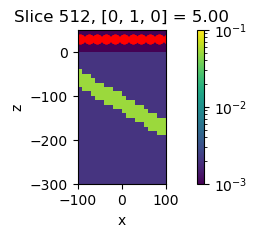

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

plt.colorbar(
    mesh.plot_slice(
        models["target_30"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(100*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

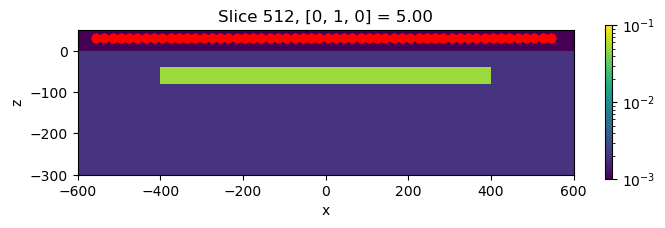

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

# mesh_local = mesh_list[-1]

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)


In [16]:
log_conductivity_models = {}

active_cells = mesh.cell_centers[:, 2] < 0

for key, val in models.items():
    log_conductivity_models[key] = np.log(val[active_cells])

In [17]:
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)
np.savetxt(f"{directory}/rx_times.txt", rx_times)
np.savetxt(f"{directory}/rx_locs.txt", rx_locs)

In [18]:
def get_sim():
    # set up survey
    source_list = []

    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    survey = tdem.Survey(source_list)

    # create simulation 
    time_steps = [
        (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 20), (1e-4, 20), (3e-4, 20)
    ]      
    msh = mesh.copy()
    active_cells_map = maps.InjectActiveCells(msh, msh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

    global_sim = tdem.simulation.Simulation3DElectricField(
        mesh=msh,
        survey=survey,
        time_steps=time_steps,
        solver=Solver,
        sigmaMap=maps.ExpMap() * active_cells_map
    )
    return global_sim

In [19]:
def run_simulation(key):
    print(f"Starting {key}")
    filename = f"{directory}/{key}.txt"
    t = time.time()
    model = log_conductivity_models[key]
    sim = get_sim()
    dpred = sim.dpred(model)
    np.savetxt(filename, dpred)
    elapsed = time.time() - t
    print(f".... done. {filename}. Elapsed time = {elapsed:1.2e}s \n")
    return key, dpred

In [20]:
dpred_dict = {}

# for key in model_keys: 
#     _, dpred_dict[key] = run_simulation(key)

with ProcessPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(run_simulation, key) for key in model_keys]
    for future in as_completed(futures):
        key, dpred = future.result()
        dpred_dict[key] = dpred

Starting target_0Starting background



/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/home/lheagy/miniforge3/envs/p

.... done. ./synthetic-data-20m/background.txt. Elapsed time = 6.40e+03s 

Starting target_15
.... done. ./synthetic-data-20m/target_0.txt. Elapsed time = 6.75e+03s 

Starting target_30
.... done. ./synthetic-data-20m/target_15.txt. Elapsed time = 6.98e+03s 

Starting target_45
.... done. ./synthetic-data-20m/target_30.txt. Elapsed time = 7.71e+03s 

.... done. ./synthetic-data-20m/target_45.txt. Elapsed time = 9.07e+03s 



In [22]:
# %%time 

# dpred_dict = {}

# for key in model_keys:
#     print(f"Starting {key}")
#     filename = f"./synthetic-data/{key}.txt"
#     t = time.time()
#     model = log_conductivity_models[key]
#     sim = get_sim()
#     dpred = sim.dpred(model)
#     np.savetxt(filename, dpred)
#     dpred_dict[key] = dpred
#     print(f".... done. {filename}. Elapsed time = {time.time()-t:1.2e}s")
    
# # sim.join()

In [23]:
dpred_dict

{'target_0': array([-6.88150376e-09, -4.86189641e-09, -3.48489058e-09, ...,
        -2.32762183e-13, -1.48810891e-13, -9.55221372e-14]),
 'target_45': array([-3.53676512e-09, -2.40283579e-09, -1.68297029e-09, ...,
        -2.08044504e-13, -1.36158188e-13, -8.91211457e-14]),
 'target_30': array([-3.60501101e-09, -2.46865108e-09, -1.73982532e-09, ...,
        -2.11792048e-13, -1.38085408e-13, -9.01039891e-14]),
 'background': array([-3.54971540e-09, -2.36290351e-09, -1.61147259e-09, ...,
        -2.02036787e-13, -1.33023325e-13, -8.75014154e-14]),
 'target_15': array([-4.28441042e-09, -3.01716692e-09, -2.17035312e-09, ...,
        -2.27399652e-13, -1.46026571e-13, -9.41119784e-14])}

In [24]:
rx_locs.shape

(51, 3)

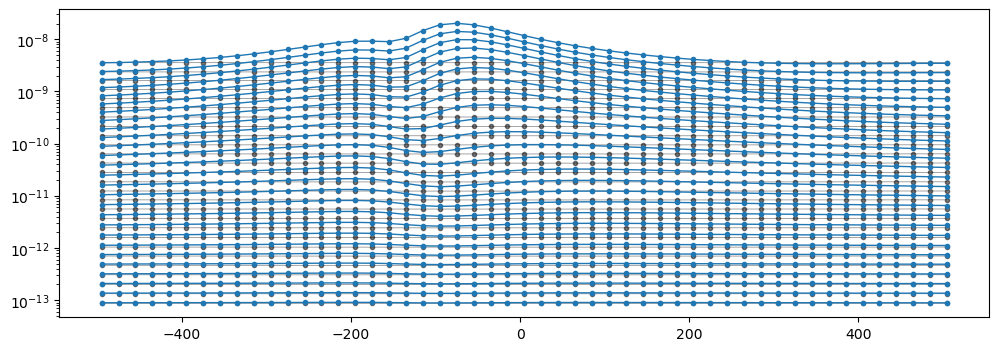

In [25]:
key = model_keys[4]
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)

n_sources = rx_locs.shape[0]
n_rxtimes = len(rx_times)

fig, ax = plt.subplots(1, 1, figsize = (12, 4)) 

ax.semilogy(rx_x, -dpred_dict[model_keys[0]].reshape(n_sources, n_rxtimes), "-k", marker=".", lw=0.5, alpha=0.5);
ax.semilogy(rx_x, -dpred_dict[key].reshape(n_sources, n_rxtimes), "-C0", marker=".", lw=1);


In [26]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# for i, key in enumerate(model_keys):
    


SyntaxError: incomplete input (3920826193.py, line 3)